In [ ]:
# atelier_TL_MLT_colab_final.ipynb

# #  Configuration Initiale

# %%
# 1. Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Créer le dossier de sauvegarde
import os
SAVE_DIR = '/content/drive/MyDrive/Colab_Models/CelebA_MultiTask'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Dossier de sauvegarde: {SAVE_DIR}")

# %%
# 3. Installation des packages
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn pillow tqdm torch torchvision torchaudio --quiet

# 4. Importations
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import json
import pickle
import time
from datetime import datetime
from tqdm import tqdm

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# #  Téléchargement du Dataset

# %%
# Configuration Kaggle
import os
os.environ['KAGGLE_USERNAME'] = "votre_username"
os.environ['KAGGLE_KEY'] = "votre_key"

# Téléchargement
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip -d /content/celeba

# Chemins
IMG_DIR = '/content/celeba/img_align_celeba/img_align_celeba'
ATTR_FILE = '/content/celeba/list_attr_celeba.csv'


Mounted at /content/drive
Dossier de sauvegarde: /content/drive/MyDrive/Colab_Models/CelebA_MultiTask
Device: cuda
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 92% 1.22G/1.33G [00:16<00:02, 42.3MB/s]
100% 1.33G/1.33G [00:16<00:00, 88.8MB/s]


In [ ]:
# #  Exploration des Données

# %%
# Chargement des annotations
df = pd.read_csv(ATTR_FILE)
print(f"Nombre d'images: {len(df)}")
print(f"Nombre d'attributs: {len(df.columns)-1}")

# Sélection des attributs cibles
TARGET_ATTRS = ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat', 'Bald', 'Mustache', 'Wearing_Lipstick']
print(f"Attributs cibles: {TARGET_ATTRS}")

# Conversion -1/1 en 0/1
df_binary = df.copy()
df_binary[TARGET_ATTRS] = df_binary[TARGET_ATTRS].replace(-1, 0)

# Sauvegarde des métadonnées
metadata = {
    'num_images': len(df),
    'target_attrs': TARGET_ATTRS,
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(f'{SAVE_DIR}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

Nombre d'images: 202599
Nombre d'attributs: 40
Attributs cibles: ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat', 'Bald', 'Mustache', 'Wearing_Lipstick']


Nombre d'images: 202599
Nombre d'attributs: 40
Attributs cibles: ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat', 'Bald', 'Mustache', 'Wearing_Lipstick']

📊 DISTRIBUTION DES ATTRIBUTS


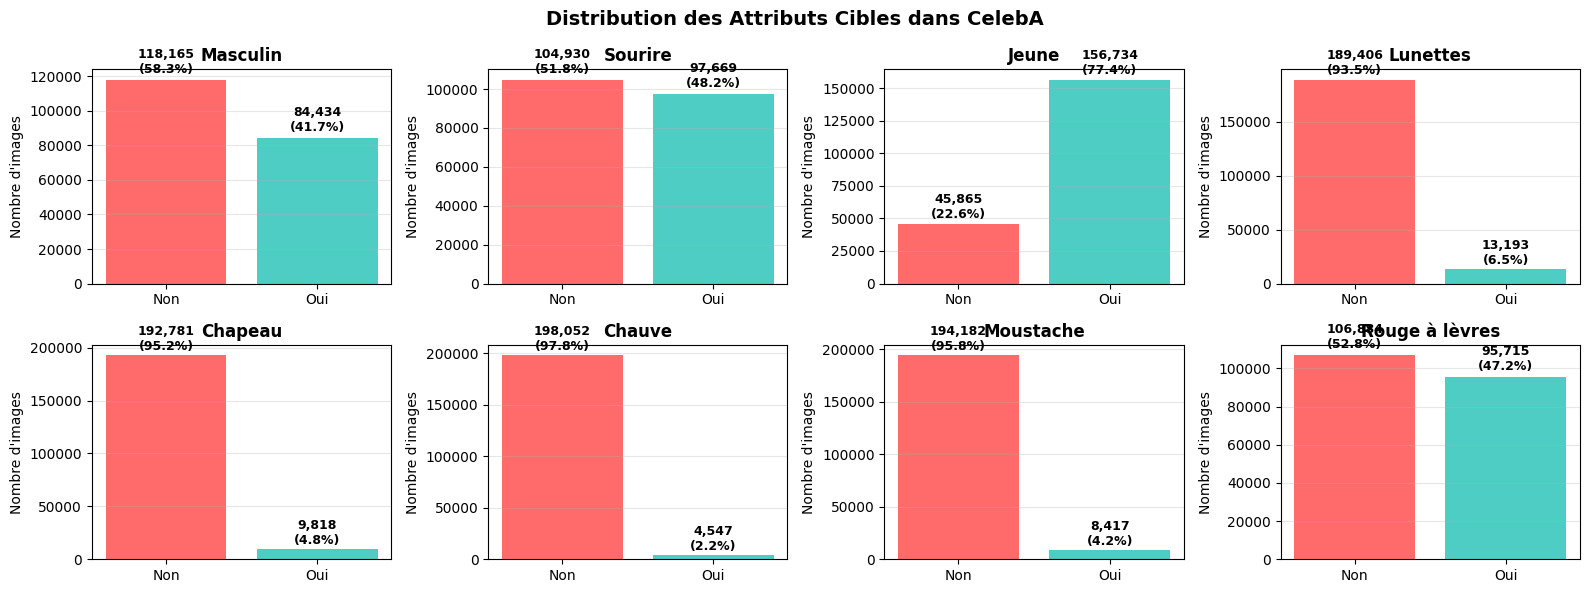


📈 ANALYSE STATISTIQUE DÉTAILLÉE
Attribut             Présence        %        Absence         %       
----------------------------------------------------------------------
Masculin             84,434          41.7     118,165         58.3    
Sourire              97,669          48.2     104,930         51.8    
Jeune                156,734         77.4     45,865          22.6    
Lunettes             13,193          6.5      189,406         93.5    
Chapeau              9,818           4.8      192,781         95.2    
Chauve               4,547           2.2      198,052         97.8    
Moustache            8,417           4.2      194,182         95.8    
Rouge à lèvres       95,715          47.2     106,884         52.8    


🔗 MATRICE DE CORRÉLATION DES ATTRIBUTS


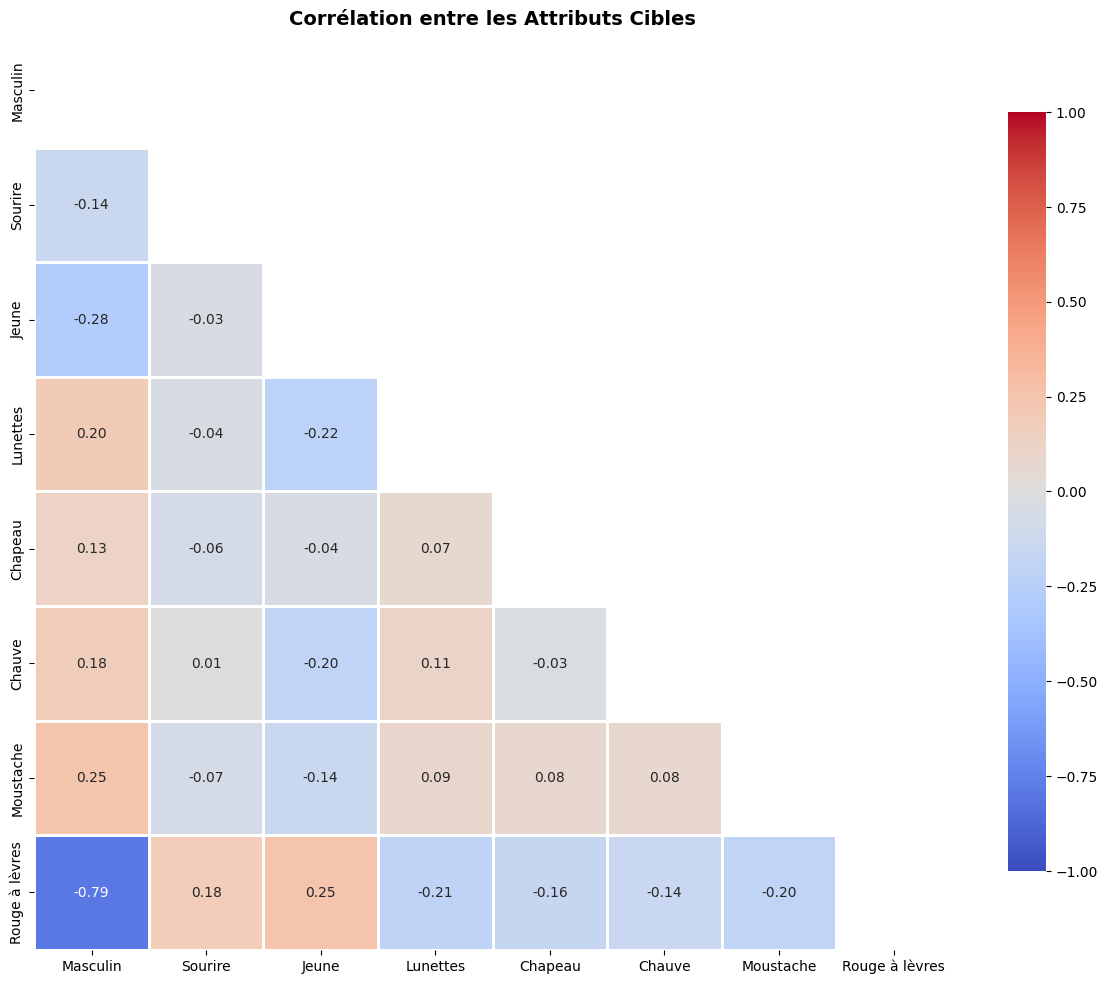


Corrélations les plus fortes (valeur absolue > 0.1):
  Masculin        ↔ Rouge à lèvres : -0.789
  Masculin        ↔ Jeune          : -0.284
  Jeune           ↔ Rouge à lèvres : +0.252
  Masculin        ↔ Moustache      : +0.246
  Jeune           ↔ Lunettes       : -0.225
  Lunettes        ↔ Rouge à lèvres : -0.208
  Masculin        ↔ Lunettes       : +0.202
  Moustache       ↔ Rouge à lèvres : -0.197
  Jeune           ↔ Chauve         : -0.196
  Sourire         ↔ Rouge à lèvres : +0.182
  Masculin        ↔ Chauve         : +0.178
  Chapeau         ↔ Rouge à lèvres : -0.160
  Chauve          ↔ Rouge à lèvres : -0.143
  Masculin        ↔ Sourire        : -0.138
  Jeune           ↔ Moustache      : -0.137
  Masculin        ↔ Chapeau        : +0.130
  Lunettes        ↔ Chauve         : +0.109

🎯 DISTRIBUTION MULTIDIMENSIONNELLE


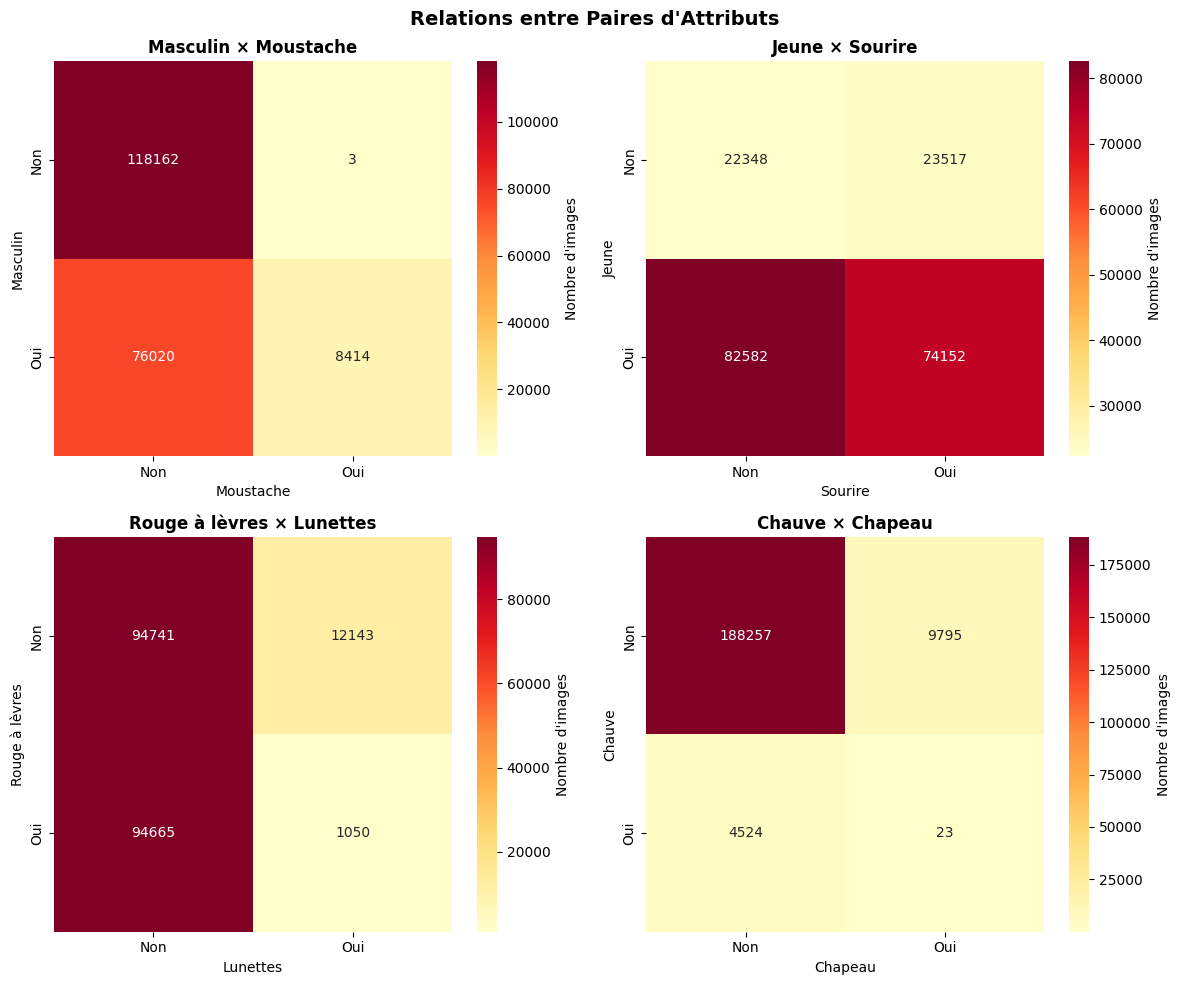


✅ Données binaires sauvegardées dans: /content/drive/MyDrive/Colab_Models/CelebA_MultiTask/attributes_binary.csv


In [ ]:
# ##  Exploration des Données

# %%
# Chargement des annotations
df = pd.read_csv(ATTR_FILE)
print(f"Nombre d'images: {len(df)}")
print(f"Nombre d'attributs: {len(df.columns)-1}")

# Sélection des attributs cibles
TARGET_ATTRS = ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat', 'Bald', 'Mustache', 'Wearing_Lipstick']
print(f"Attributs cibles: {TARGET_ATTRS}")

# Conversion -1/1 en 0/1
df_binary = df.copy()
df_binary[TARGET_ATTRS] = df_binary[TARGET_ATTRS].replace(-1, 0)

# Sauvegarde des métadonnées
metadata = {
    'num_images': len(df),
    'target_attrs': TARGET_ATTRS,
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(f'{SAVE_DIR}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

# %%
# VISUALISATION DES DISTRIBUTIONS
print("\n📊 DISTRIBUTION DES ATTRIBUTS")
print("=" * 60)

# Définir les noms en français pour l'affichage
ATTR_NAMES_FR = {
    'Male': 'Masculin',
    'Smiling': 'Sourire',
    'Young': 'Jeune',
    'Eyeglasses': 'Lunettes',
    'Wearing_Hat': 'Chapeau',
    'Bald': 'Chauve',
    'Mustache': 'Moustache',
    'Wearing_Lipstick': 'Rouge à lèvres'
}

# Créer un subplot avec une disposition adaptée au nombre d'attributs
num_attrs = len(TARGET_ATTRS)
num_cols = 4  # Nombre de colonnes dans la grille
num_rows = (num_attrs + num_cols - 1) // num_cols  # Calcul du nombre de lignes nécessaires

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 3))
axes = axes.flatten()

for i, attr in enumerate(TARGET_ATTRS):
    # Compter les valeurs
    counts = df_binary[attr].value_counts().sort_index()

    # S'assurer d'avoir 0 et 1
    if 0 not in counts.index:
        counts[0] = 0
    if 1 not in counts.index:
        counts[1] = 0

    counts = counts.sort_index()

    # Créer le graphique à barres
    bars = axes[i].bar(['Non', 'Oui'],
                      [counts.get(0, 0), counts.get(1, 0)],
                      color=['#FF6B6B', '#4ECDC4'])

    axes[i].set_title(f'{ATTR_NAMES_FR[attr]}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Nombre d\'images', fontsize=10)
    axes[i].grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    total = len(df_binary)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / total) * 100
        axes[i].text(bar.get_x() + bar.get_width()/2, height + total * 0.01,
                    f'{height:,}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Cacher les axes inutilisés
for i in range(num_attrs, len(axes)):
    axes[i].axis('off')

plt.suptitle('Distribution des Attributs Cibles dans CelebA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# ANALYSE STATISTIQUE DÉTAILLÉE
print("\n📈 ANALYSE STATISTIQUE DÉTAILLÉE")
print("=" * 60)

print(f"{'Attribut':<20} {'Présence':<15} {'%':<8} {'Absence':<15} {'%':<8}")
print("-" * 70)

stats_data = []
for attr in TARGET_ATTRS:
    positive = df_binary[attr].sum()
    total = len(df_binary)
    negative = total - positive
    pos_pct = (positive / total) * 100
    neg_pct = (negative / total) * 100

    stats_data.append({
        'attribut': attr,
        'présence': positive,
        'présence_%': pos_pct,
        'absence': negative,
        'absence_%': neg_pct
    })

    print(f"{ATTR_NAMES_FR[attr]:<20} {positive:<15,} {pos_pct:<8.1f} {negative:<15,} {neg_pct:<8.1f}")

# Créer un DataFrame pour les statistiques
stats_df = pd.DataFrame(stats_data)
print(f"\n{'='*70}")

# %%
# MATRICE DE CORRÉLATION
print("\n🔗 MATRICE DE CORRÉLATION DES ATTRIBUTS")
print("=" * 60)

plt.figure(figsize=(12, 10))
corr_matrix = df_binary[TARGET_ATTRS].corr()

# Créer un masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f',
            square=True,
            cbar_kws={"shrink": .8},
            linewidths=1,
            linecolor='white',
            xticklabels=[ATTR_NAMES_FR[a] for a in TARGET_ATTRS],
            yticklabels=[ATTR_NAMES_FR[a] for a in TARGET_ATTRS])

plt.title('Corrélation entre les Attributs Cibles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Afficher les corrélations les plus fortes
print("\nCorrélations les plus fortes (valeur absolue > 0.1):")
corr_pairs = []
for i in range(len(TARGET_ATTRS)):
    for j in range(i+1, len(TARGET_ATTRS)):
        attr1, attr2 = TARGET_ATTRS[i], TARGET_ATTRS[j]
        corr = corr_matrix.loc[attr1, attr2]
        if abs(corr) > 0.1:
            corr_pairs.append((attr1, attr2, corr))

# Trier par valeur absolue
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for attr1, attr2, corr in corr_pairs:
    print(f"  {ATTR_NAMES_FR[attr1]:<15} ↔ {ATTR_NAMES_FR[attr2]:<15}: {corr:+.3f}")

# %%
# DISTRIBUTION MULTIDIMENSIONNELLE
print("\n🎯 DISTRIBUTION MULTIDIMENSIONNELLE")
print("=" * 60)

# Exemple: combinaison de deux attributs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

combinations = [
    ('Male', 'Mustache'),
    ('Young', 'Smiling'),
    ('Wearing_Lipstick', 'Eyeglasses'),
    ('Bald', 'Wearing_Hat')
]

for idx, (attr1, attr2) in enumerate(combinations):
    # Créer une table de contingence
    contingency = pd.crosstab(df_binary[attr1], df_binary[attr2])

    # S'assurer que la table a la bonne forme
    for val in [0, 1]:
        if val not in contingency.index:
            contingency.loc[val] = [0, 0]
        if val not in contingency.columns:
            contingency[val] = [0, 0]

    contingency = contingency.sort_index().sort_index(axis=1)

    # Créer le heatmap
    sns.heatmap(contingency,
                annot=True,
                fmt='d',
                cmap='YlOrRd',
                cbar_kws={'label': 'Nombre d\'images'},
                ax=axes[idx])

    axes[idx].set_title(f'{ATTR_NAMES_FR[attr1]} × {ATTR_NAMES_FR[attr2]}', fontweight='bold')
    axes[idx].set_xlabel(ATTR_NAMES_FR[attr2])
    axes[idx].set_ylabel(ATTR_NAMES_FR[attr1])
    axes[idx].set_xticklabels(['Non', 'Oui'])
    axes[idx].set_yticklabels(['Non', 'Oui'])

plt.suptitle('Relations entre Paires d\'Attributs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Sauvegarder les données binaires pour une utilisation ultérieure
df_binary.to_csv(f'{SAVE_DIR}/attributes_binary.csv', index=False)
print(f"\n✅ Données binaires sauvegardées dans: {SAVE_DIR}/attributes_binary.csv")


🖼️ VISUALISATION D'EXEMPLES D'IMAGES


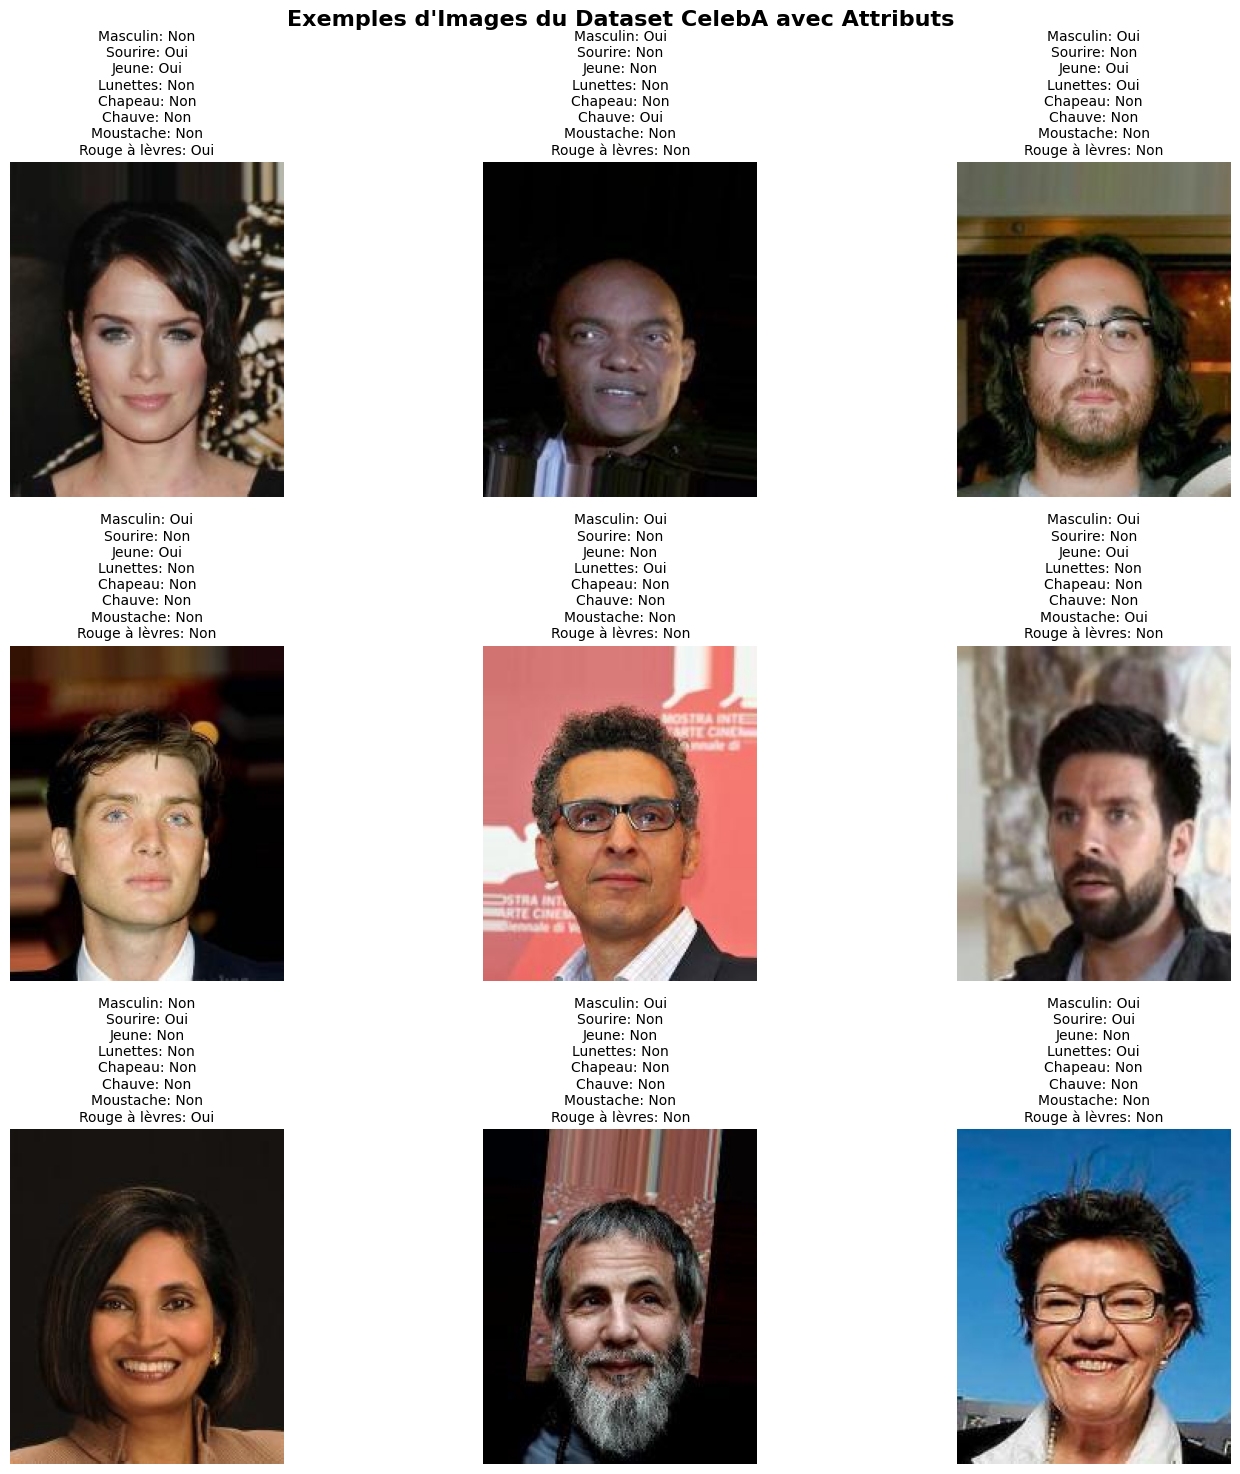


✅ Visualisation sauvegardée dans: /content/drive/MyDrive/Colab_Models/CelebA_MultiTask/sample_images_visualization.png


In [ ]:
# %%
# VISUALISATION D'EXEMPLES D'IMAGES AVEC ATTRIBUTS
print("\n🖼️ VISUALISATION D'EXEMPLES D'IMAGES")
print("=" * 60)

import random

# Sélectionner aléatoirement des images (par exemple, 9 pour une grille 3x3)
num_images_to_show = 9
random_image_ids = random.sample(df_binary['image_id'].tolist(), num_images_to_show)

# Créer une figure avec une grille de subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, image_id in enumerate(random_image_ids):
    # Chemin de l'image
    img_path = os.path.join(IMG_DIR, image_id)

    # Ouvrir et afficher l'image
    img = Image.open(img_path)
    axes[idx].imshow(img)

    # Récupérer les attributs pour cette image
    attrs = df_binary[df_binary['image_id'] == image_id][TARGET_ATTRS].iloc[0]

    # Créer un titre avec les attributs (en français pour cohérence)
    title_lines = [f"{ATTR_NAMES_FR[attr]}: {'Oui' if attrs[attr] == 1 else 'Non'}" for attr in TARGET_ATTRS]
    title = '\n'.join(title_lines)

    # Définir le titre et masquer les axes
    axes[idx].set_title(title, fontsize=10)
    axes[idx].axis('off')

# Ajuster la disposition
plt.suptitle('Exemples d\'Images du Dataset CelebA avec Attributs', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Optionnel : Sauvegarder la figure
fig.savefig(f'{SAVE_DIR}/sample_images_visualization.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Visualisation sauvegardée dans: {SAVE_DIR}/sample_images_visualization.png")


════════════════════════════════════════════════════════════
4.1 SPLIT TRAIN / VALIDATION / TEST
════════════════════════════════════════════════════════════
Total images          : 202,599
Train                 : 141,819 ( 70.0%)
Validation            : 30,390 ( 15.0%)
Test                  : 30,390 ( 15.0%)

════════════════════════════════════════════════════════════
4.2 TRANSFORMATIONS D'IMAGES (PyTorch)
════════════════════════════════════════════════════════════
Transformations définies :
→ Train : augmentation + normalisation
→ Val/Test : redimensionnement + normalisation uniquement

════════════════════════════════════════════════════════════
4.3 CRÉATION DU DATASET PYTORCH
════════════════════════════════════════════════════════════
Train dataset   : 141,819 images
Val dataset     : 30,390 images
Test dataset    : 30,390 images

DataLoaders créés avec batch_size = 64

════════════════════════════════════════════════════════════
4.5 VISUALISATION DES IMAGES APRÈS PRÉTRAITEMENT

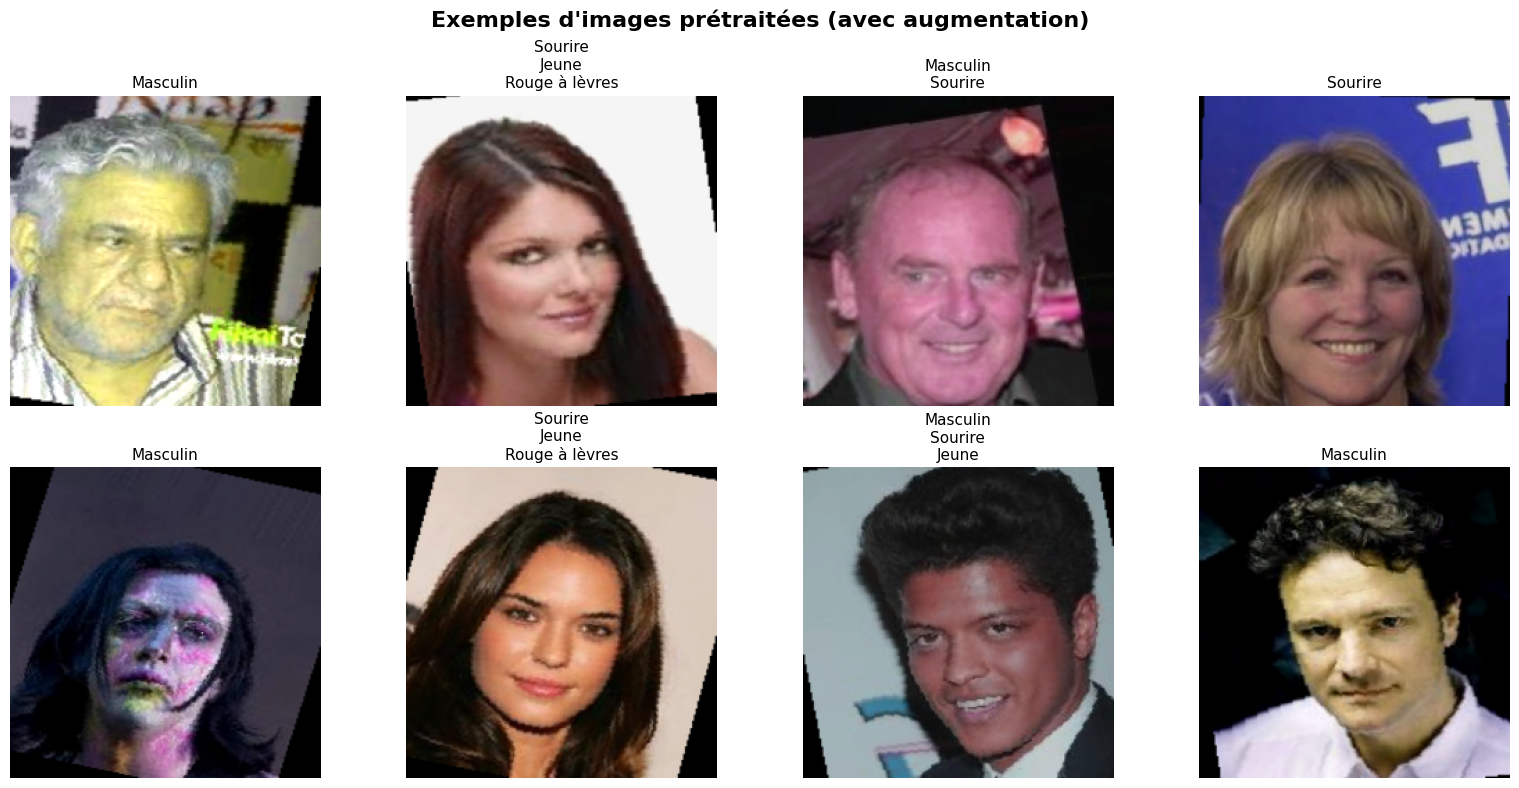


 Visualisation des images prétraitées sauvegardée dans /content/drive/MyDrive/Colab_Models/CelebA_MultiTask/preprocessed_samples.png


In [ ]:
# %% md
# # 4. Prétraitement des données

# %%
# 4.1 Préparation des données d’entraînement et de test
print("\n" + "═" * 60)
print("4.1 SPLIT TRAIN / VALIDATION / TEST")
print("═" * 60)

# On utilise la colonne 'image_id' qui contient le nom des fichiers
image_ids = df['image_id'].tolist()

# Split stratifié ? Pas possible directement avec plusieurs labels → split aléatoire classique
train_ids, temp_ids = train_test_split(
    image_ids, test_size=0.3, random_state=42, stratify=None
)

val_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, random_state=42
)

print(f"Total images          : {len(image_ids):,}")
print(f"Train                 : {len(train_ids):,} ({len(train_ids)/len(image_ids)*100:5.1f}%)")
print(f"Validation            : {len(val_ids):,} ({len(val_ids)/len(image_ids)*100:5.1f}%)")
print(f"Test                  : {len(test_ids):,} ({len(test_ids)/len(image_ids)*100:5.1f}%)")

# Sauvegarde des splits pour reproductibilité
splits = {
    'train': train_ids,
    'val': val_ids,
    'test': test_ids,
    'random_state': 42
}
with open(f'{SAVE_DIR}/data_splits.json', 'w') as f:
    json.dump(splits, f, indent=4)

# %%
# 4.2 Prétraitement des images
print("\n" + "═" * 60)
print("4.2 TRANSFORMATIONS D'IMAGES (PyTorch)")
print("═" * 60)

# Transformations communes à train / val / test
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),           # Taille standard ResNet / EfficientNet
    transforms.CenterCrop(224),
])

# Transformations spécifiques à l'entraînement (data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet stats
                         std =[0.229, 0.224, 0.225]),
])

# Transformations pour validation et test (pas d'augmentation)
val_test_transforms = transforms.Compose([
    common_transforms,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

print("Transformations définies :")
print("→ Train : augmentation + normalisation")
print("→ Val/Test : redimensionnement + normalisation uniquement")

# %%
# 4.3 Dataset PyTorch personnalisé
print("\n" + "═" * 60)
print("4.3 CRÉATION DU DATASET PYTORCH")
print("═" * 60)

class CelebADataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.image_ids = image_ids
        self.transform = transform
        # On garde uniquement les colonnes utiles
        self.labels = df_binary.set_index('image_id').loc[image_ids][TARGET_ATTRS].values.astype(np.float32)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(IMG_DIR, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx])
        return image, label

# Création des datasets
train_dataset = CelebADataset(train_ids, transform=train_transforms)
val_dataset   = CelebADataset(val_ids,   transform=val_test_transforms)
test_dataset  = CelebADataset(test_ids,  transform=val_test_transforms)

print(f"Train dataset   : {len(train_dataset):,} images")
print(f"Val dataset     : {len(val_dataset):,} images")
print(f"Test dataset    : {len(test_dataset):,} images")

# %%
# 4.4 DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataLoaders créés avec batch_size = {BATCH_SIZE}")

# %%
# 4.5 Visualisation des images prétraitées
print("\n" + "═" * 60)
print("4.5 VISUALISATION DES IMAGES APRÈS PRÉTRAITEMENT")
print("═" * 60)

def imshow_tensor(img, ax=None, title=None):
    """Fonction utilitaire pour afficher un tenseur normalisé"""
    if ax is None:
        ax = plt.gca()
    # Dénormalisation
    img = img.clone().detach()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        ax.set_title(title)
    ax.axis('off')

# Prendre un batch du train_loader
images, labels = next(iter(train_loader))

# Afficher 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    imshow_tensor(images[i], axes[i])
    # Titre avec les attributs présents
    active_attrs = [ATTR_NAMES_FR[TARGET_ATTRS[j]] for j in range(len(TARGET_ATTRS)) if labels[i][j] == 1]
    title = "\n".join(active_attrs) if active_attrs else "Aucun attribut majeur"
    axes[i].set_title(title, fontsize=11)

plt.suptitle("Exemples d'images prétraitées (avec augmentation)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Sauvegarde
fig.savefig(f'{SAVE_DIR}/preprocessed_samples.png', dpi=300, bbox_inches='tight')
print(f"\n Visualisation des images prétraitées sauvegardée dans {SAVE_DIR}/preprocessed_samples.png")

In [ ]:
# %%
# SAUVEGARDE COMPLÈTE ET IRRÉVERSIBLE DANS GOOGLE DRIVE

import torch
import pickle
import json

print("SAUVEGARDE FINALE DE TOUT LE PRÉTRAITEMENT")
print("=" * 60)

# 1. Sauvegarde des splits (déjà fait, mais on le refait pour être sûr)
splits = {
    'train_ids': train_ids,
    'val_ids':   val_ids,
    'test_ids':  test_ids,
    'random_state': 42
}
with open(f'{SAVE_DIR}/final_splits.json', 'w') as f:
    json.dump(splits, f, indent=4)

# 2. Sauvegarde des Datasets PyTorch complets (avec les transforms déjà appliqués au moment du chargement)
torch.save({
    'train_dataset': train_dataset,
    'val_dataset':   val_dataset,
    'test_dataset':  test_dataset,
}, f'{SAVE_DIR}/final_datasets.pth')

# 3. Sauvegarde des DataLoaders (pratiques pour l'entraînement direct)
torch.save({
    'train_loader': train_loader,
    'val_loader':   val_loader,
    'test_loader':  test_loader,
    'batch_size': BATCH_SIZE
}, f'{SAVE_DIR}/final_dataloaders.pth')

# 4. Sauvegarde des transformations (pour référence)
with open(f'{SAVE_DIR}/transforms.pkl', 'wb') as f:
    pickle.dump({
        'train_transforms': train_transforms,
        'val_test_transforms': val_test_transforms
    }, f)

print("TOUT EST SAUVEGARDÉ DANS TON DRIVE :")
print(f"   → {SAVE_DIR}/")
print("")
print("   final_splits.json")        # → les listes d'IDs
print("   final_datasets.pth")       # → les 3 Dataset PyTorch
print("   final_dataloaders.pth")     # → les 3 DataLoader prêts à l'emploi
print("   transforms.pkl")            # → les transformations exactes
print("")
print("Tu peux maintenant fermer Colab et tout recharger plus tard avec :")

print("""
# === RECHARGEMENT ULTRA-RAPIDE ===
data = torch.load(f'{SAVE_DIR}/final_dataloaders.pth')
train_loader = data['train_loader']
val_loader   = data['val_loader']
test_loader  = data['test_loader']

# ou si tu veux les datasets :
datasets = torch.load(f'{SAVE_DIR}/final_datasets.pth')
train_dataset = datasets['train_dataset']
val_dataset   = datasets['val_dataset']
test_dataset  = datasets['test_dataset']
""")

SAUVEGARDE FINALE DE TOUT LE PRÉTRAITEMENT
TOUT EST SAUVEGARDÉ DANS TON DRIVE :
   → /content/drive/MyDrive/Colab_Models/CelebA_MultiTask/

   final_splits.json
   final_datasets.pth
   final_dataloaders.pth
   transforms.pkl

Tu peux maintenant fermer Colab et tout recharger plus tard avec :

# === RECHARGEMENT ULTRA-RAPIDE ===
data = torch.load(f'{SAVE_DIR}/final_dataloaders.pth')
train_loader = data['train_loader']
val_loader   = data['val_loader']
test_loader  = data['test_loader']

# ou si tu veux les datasets :
datasets = torch.load(f'{SAVE_DIR}/final_datasets.pth')
train_dataset = datasets['train_dataset']
val_dataset   = datasets['val_dataset']
test_dataset  = datasets['test_dataset']



In [ ]:
# Vérification complète de ce qui est bien dans ton Drive
print("CONTENU DE TON DOSSIER DE SAUVEGARDE")
print("=" * 70)
!ls -lh "/content/drive/MyDrive/Colab_Models/CelebA_MultiTask/"

print("\nDétail des gros fichiers (les plus importants) :")
print("-" * 70)
!ls -lh "/content/drive/MyDrive/Colab_Models/CelebA_MultiTask/"*.pth
!ls -lh "/content/drive/MyDrive/Colab_Models/CelebA_MultiTask/"*.json
!ls -lh "/content/drive/MyDrive/Colab_Models/CelebA_MultiTask/"*.csv
!ls -lh "/content/drive/MyDrive/Colab_Models/CelebA_MultiTask/"*.pkl
!ls -lh "/content/drive/MyDrive/Colab_Models/CelebA_MultiTask/"*.png

CONTENU DE TON DOSSIER DE SAUVEGARDE
total 54M
-rw------- 1 root root  23M Dec  7 12:04 attributes_binary.csv
-rw------- 1 root root 4.3M Dec  7 12:05 data_splits.json
-rw------- 1 root root  11M Dec  7 12:05 final_dataloaders.pth
-rw------- 1 root root  11M Dec  7 12:05 final_datasets.pth
-rw------- 1 root root 4.3M Dec  7 12:05 final_splits.json
-rw------- 1 root root  252 Dec  7 12:04 metadata.json
-rw------- 1 root root 979K Dec  7 12:05 preprocessed_samples.png
-rw------- 1 root root 1.1M Dec  7 12:04 sample_images_visualization.png
-rw------- 1 root root 2.1K Dec  7 12:05 transforms.pkl

Détail des gros fichiers (les plus importants) :
----------------------------------------------------------------------
-rw------- 1 root root 11M Dec  7 12:05 /content/drive/MyDrive/Colab_Models/CelebA_MultiTask/final_dataloaders.pth
-rw------- 1 root root 11M Dec  7 12:05 /content/drive/MyDrive/Colab_Models/CelebA_MultiTask/final_datasets.pth
-rw------- 1 root root 4.3M Dec  7 12:05 /content/dr

In [ ]:
# %%
# 5. Modèle Multi-tâches – VERSION CORRIGÉE ET ROBUSTE (EfficientNet-B0)

import torch
import torch.nn as nn
from torchvision import models

print("CRÉATION DU MODÈLE MULTI-TÂCHES (EfficientNet-B0)")
print("=" * 60)

NUM_TASKS = len(TARGET_ATTRS)  # = 8

# === CHARGEMENT EFFICIENTNET-B0 (pré-entraîné ImageNet) ===
# Attention : la structure est différente de ResNet !
backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")  # ou pretrained=True si ancienne version
# On freeze la backbone (optionnel mais recommandé au début)
for param in backbone.parameters():
    param.requires_grad = False

# === Extraction du nombre de features ===
# Chez EfficientNet, la dernière couche avant classifier est : backbone.features[-1] (c'est un Conv2d)
# Puis il y a avgpool + classifier
x = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    features = backbone.features(x)      # → [1, 1280, 7, 7]
    features = backbone.avgpool(features) # → [1, 1280, 1, 1]
    features = torch.flatten(features, 1) # → [1, 1280]
    num_features = features.shape[1]

print(f"Nombre de features extraites : {num_features}")  # Doit afficher 1280

# On remplace le classifier final par Identity
backbone.classifier = nn.Identity()

class MultiTaskCelebA(nn.Module):
    def __init__(self, backbone, num_features, num_tasks):
        super().__init__()
        self.backbone = backbone

        # 8 têtes indépendantes (une par attribut)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(num_features, 1)
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        features = self.backbone(x)                    # → [B, 1280]
        outputs = []
        for head in self.heads:
            out = head(features)
            outputs.append(torch.sigmoid(out).squeeze(1))
        return torch.stack(outputs, dim=1)             # → [B, 8]

# Création du modèle
model = MultiTaskCelebA(backbone, num_features, NUM_TASKS)
model = model.to(device)

# Défreeze les têtes (elles doivent s'entraîner)
for head in model.heads:
    for param in head.parameters():
        param.requires_grad = True

# Vérifions le nombre de paramètres entraînables
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Paramètres totaux      : {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,} (seulement les 8 têtes)")
print(f"Device                 : {device}")

CRÉATION DU MODÈLE MULTI-TÂCHES (EfficientNet-B0)
Nombre de features extraites : 1280
Paramètres totaux      : 4,017,796
Paramètres entraînables: 10,248 (seulement les 8 têtes)
Device                 : cuda


DÉMARRAGE DE L'ENTRAÎNEMENT MULTI-TÂCHES (8 attributs)
Époques max      : 15
Paramètres entraînables : 10,248
Sauvegarde → /content/drive/MyDrive/ISIC_2019_Project/models
----------------------------------------------------------------------

ÉPOQUE 1/15 ----------------------------------------


Train 1:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   1:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2651 | Val Loss : 0.2245 | LR : 1.00e-03
NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !

ÉPOQUE 2/15 ----------------------------------------


Train 2:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   2:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2504 | Val Loss : 0.2170 | LR : 1.00e-03
NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !

ÉPOQUE 3/15 ----------------------------------------


Train 3:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   3:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2479 | Val Loss : 0.2202 | LR : 1.00e-03

ÉPOQUE 4/15 ----------------------------------------


Train 4:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   4:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2475 | Val Loss : 0.2154 | LR : 1.00e-03
NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !

ÉPOQUE 5/15 ----------------------------------------


Train 5:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   5:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2471 | Val Loss : 0.2141 | LR : 1.00e-03
NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !

ÉPOQUE 6/15 ----------------------------------------


Train 6:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   6:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2467 | Val Loss : 0.2133 | LR : 1.00e-03
NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !

ÉPOQUE 7/15 ----------------------------------------


Train 7:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   7:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2465 | Val Loss : 0.2128 | LR : 1.00e-03
NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !

ÉPOQUE 8/15 ----------------------------------------


Train 8:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   8:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2463 | Val Loss : 0.2141 | LR : 1.00e-03

ÉPOQUE 9/15 ----------------------------------------


Train 9:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   9:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2457 | Val Loss : 0.2140 | LR : 1.00e-03

ÉPOQUE 10/15 ----------------------------------------


Train 10:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   10:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2458 | Val Loss : 0.2164 | LR : 5.00e-04

ÉPOQUE 11/15 ----------------------------------------


Train 11:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   11:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2440 | Val Loss : 0.2141 | LR : 5.00e-04

ÉPOQUE 12/15 ----------------------------------------


Train 12:   0%|          | 0/2216 [00:00<?, ?it/s]

Val   12:   0%|          | 0/475 [00:00<?, ?it/s]

Train Loss : 0.2431 | Val Loss : 0.2143 | LR : 5.00e-04

Early stopping déclenché à l'époque 12

ENTRAÎNEMENT TERMINÉ !
Meilleur Val Loss : 0.2128
Modèle final → /content/drive/MyDrive/ISIC_2019_Project/models/BEST_MULTITASK_MODEL.pth


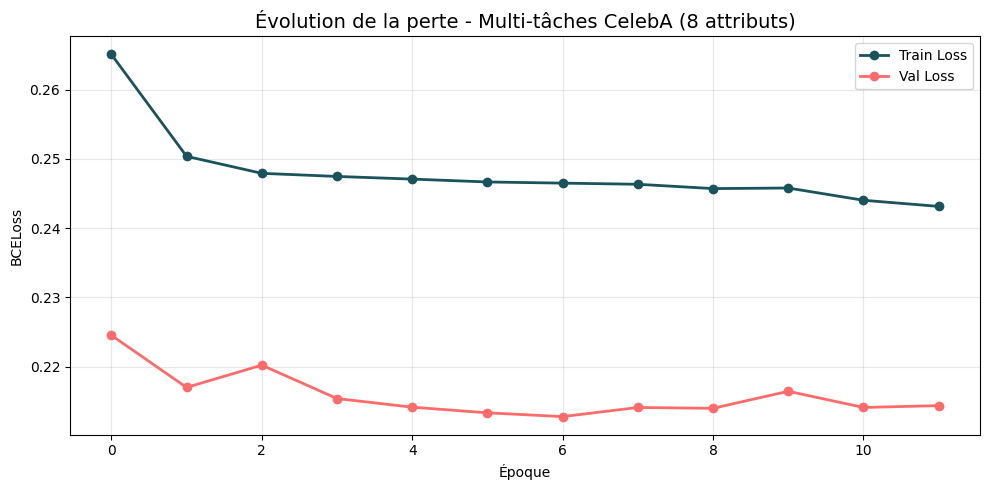

In [ ]:
# %%
# LANCEMENT DE L'ENTRAÎNEMENT – VERSION 100 % FONCTIONNELLE (corrigé verbose)

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

print("DÉMARRAGE DE L'ENTRAÎNEMENT MULTI-TÂCHES (8 attributs)")
print("=" * 70)

# Hyperparamètres
NUM_EPOCHS = 15
PATIENCE = 5

# Loss + Optimizer + Scheduler (corrigé)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # ← corrigé

# Dossier modèles
MODEL_DIR = f"{SAVE_DIR}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Historique
history = {"train_loss": [], "val_loss": []}
best_val_loss = float('inf')
no_improve = 0

print(f"Époques max      : {NUM_EPOCHS}")
print(f"Paramètres entraînables : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Sauvegarde → {MODEL_DIR}")
print("-" * 70)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nÉPOQUE {epoch}/{NUM_EPOCHS} {'-'*40}")

    # TRAIN
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Train {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    history["train_loss"].append(train_loss)

    # VALIDATION
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Val   {epoch}", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    # Scheduler
    scheduler.step(val_loss)

    # Affichage
    print(f"Train Loss : {train_loss:.4f} | Val Loss : {val_loss:.4f} | LR : {optimizer.param_groups[0]['lr']:.2e}")

    # Sauvegarde meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history,
            'target_attrs': TARGET_ATTRS
        }, f"{MODEL_DIR}/BEST_MULTITASK_MODEL.pth")
        print("NOUVEAU MEILLEUR MODÈLE SAUVEGARDÉ !")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"\nEarly stopping déclenché à l'époque {epoch}")
            break

print("\nENTRAÎNEMENT TERMINÉ !")
print(f"Meilleur Val Loss : {best_val_loss:.4f}")
print(f"Modèle final → {MODEL_DIR}/BEST_MULTITASK_MODEL.pth")

# Courbe finale
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], 'o-', label='Train Loss', color='#1A535C', linewidth=2)
plt.plot(history['val_loss'], 'o-', label='Val Loss', color='#FF6B6B', linewidth=2)
plt.title('Évolution de la perte - Multi-tâches CelebA (8 attributs)', fontsize=14)
plt.xlabel('Époque')
plt.ylabel('BCELoss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/final_training_curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(model)
# OU
print(type(model))
# OU
for name, module in model.named_children():
    print(f"{name}: {type(module)}")

MultiTaskCelebA(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sc

In [ ]:
# ============================================================================
# FINE-TUNING MULTITASKCELEBA - EFFICIENTNET B0 (8 ATTRIBUTS)
# Architecture : backbone.features (EfficientNet) + heads (8 Linear)
# Stratégie : Unfreeze progressif optimisé
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import numpy as np

print(" DÉMARRAGE DU FINE-TUNING AVANCÉ - MULTITASKCELEBA")
print("=" * 70)

# ============================================================================
# 1. CHARGEMENT DU MEILLEUR MODÈLE PRÉ-ENTRAÎNÉ
# ============================================================================

CHECKPOINT_PATH = f"{MODEL_DIR}/BEST_MULTITASK_MODEL.pth"
checkpoint = torch.load(CHECKPOINT_PATH)

print(f" Modèle chargé depuis : {CHECKPOINT_PATH}")
print(f"   Val Loss initial : {checkpoint['val_loss']:.4f}")
print(f"   Époque d'origine : {checkpoint['epoch']}")

# Recharger les poids
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

print(f"\n Architecture MultiTaskCelebA détectée :")
print(f"   - Backbone : EfficientNet-B0 ({sum(p.numel() for p in model.backbone.parameters()):,} params)")
print(f"   - Heads    : 8 classifiers ({sum(p.numel() for p in model.heads.parameters()):,} params)")

# ============================================================================
# 2. CONFIGURATION DU FINE-TUNING PROGRESSIF
# ============================================================================

NUM_EPOCHS_FT = 20
PATIENCE_FT = 7
WARMUP_EPOCHS = 3

print(f"\n  Hyperparamètres Fine-Tuning :")
print(f"   Époques max       : {NUM_EPOCHS_FT}")
print(f"   Patience          : {PATIENCE_FT}")
print(f"   Warmup            : {WARMUP_EPOCHS} époques")

# ============================================================================
# 3. PHASE 1 : FINE-TUNING LÉGER (TÊTE + DERNIERS BLOCS)
# ============================================================================

print(f"\n PHASE 1 : Fine-tuning tête + derniers blocs (époques 1-{WARMUP_EPOCHS})")

# Geler tout le backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Dégeler les 3 derniers blocs du backbone (features[5], [6], [7])
for i in [5, 6, 7]:
    for param in model.backbone.features[i].parameters():
        param.requires_grad = True

# Dégeler la couche finale de convolution (features[8])
for param in model.backbone.features[8].parameters():
    param.requires_grad = True

# Dégeler toutes les têtes de classification
for head in model.heads:
    for param in head.parameters():
        param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f" Paramètres entraînables : {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

# Optimizer avec learning rates différenciés
backbone_params = [p for n, p in model.named_parameters()
                   if p.requires_grad and 'heads' not in n]
head_params = [p for p in model.heads.parameters()]

optimizer_ft = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5, 'weight_decay': 1e-4},  # LR faible backbone
    {'params': head_params, 'lr': 3e-4, 'weight_decay': 1e-4}       # LR moyen têtes
])

print(f" Optimizer : 2 groupes de LR (backbone=1e-5, heads=3e-4)")

# Scheduler : Cosine Annealing avec Warm Restarts
scheduler_ft = CosineAnnealingWarmRestarts(
    optimizer_ft,
    T_0=5,
    T_mult=2,
    eta_min=1e-7
)

# ============================================================================
# 4. LOSS AVEC LABEL SMOOTHING
# ============================================================================

class BCEWithLabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.05):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

criterion_ft = BCEWithLabelSmoothing(smoothing=0.05)
print(f" Loss : BCELoss avec Label Smoothing (0.05)")

# ============================================================================
# 5. FONCTIONS D'ENTRAÎNEMENT OPTIMISÉES
# ============================================================================

def train_epoch_ft(model, loader, criterion, optimizer, device, accumulation_steps=2):
    """Entraînement avec gradient accumulation"""
    model.train()
    running_loss = 0.0

    optimizer.zero_grad()
    for i, (images, labels) in enumerate(tqdm(loader, desc='🔥 Training', leave=False)):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

    return running_loss / len(loader)

def validate_ft(model, loader, criterion, device):
    """Validation avec métriques par attribut"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='✅ Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Accuracy par attribut
    preds_binary = (all_preds > 0.5).float()
    accuracies = (preds_binary == all_labels).float().mean(dim=0)

    return running_loss / len(loader), accuracies

# ============================================================================
# 6. BOUCLE D'ENTRAÎNEMENT FINE-TUNING
# ============================================================================

history_ft = {
    "train_loss": [],
    "val_loss": [],
    "lr": [],
    "accuracies": []
}
best_val_loss_ft = checkpoint['val_loss']
no_improve_ft = 0

print("\n" + "=" * 70)
print(" LANCEMENT DU FINE-TUNING")
print("=" * 70)

for epoch in range(1, NUM_EPOCHS_FT + 1):
    print(f"\n ÉPOQUE {epoch}/{NUM_EPOCHS_FT} {'-'*40}")

    # ========================================================================
    # PHASE 2 : DÉGEL COMPLET APRÈS WARMUP
    # ========================================================================
    if epoch == WARMUP_EPOCHS + 1:
        print("\n PHASE 2 : Dégel complet du modèle")

        # Tout dégeler
        for param in model.parameters():
            param.requires_grad = True

        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in model.parameters())
        print(f" Paramètres entraînables : {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

        # Nouveau optimizer avec LR très faible
        optimizer_ft = optim.AdamW(model.parameters(), lr=5e-6, weight_decay=1e-4)
        scheduler_ft = CosineAnnealingWarmRestarts(optimizer_ft, T_0=5, T_mult=2, eta_min=1e-7)
        print(" Optimizer réinitialisé avec LR global = 5e-6")

    # TRAIN
    train_loss = train_epoch_ft(model, train_loader, criterion_ft, optimizer_ft, device)
    history_ft["train_loss"].append(train_loss)

    # VALIDATION
    val_loss, accuracies = validate_ft(model, val_loader, criterion_ft, device)
    history_ft["val_loss"].append(val_loss)
    history_ft["accuracies"].append(accuracies.numpy())

    # Scheduler step
    scheduler_ft.step()
    current_lr = optimizer_ft.param_groups[0]['lr']
    history_ft["lr"].append(current_lr)

    # Affichage
    mean_acc = accuracies.mean().item()
    print(f" Train Loss : {train_loss:.4f} | Val Loss : {val_loss:.4f}")
    print(f" Accuracy   : {mean_acc:.2%} | LR : {current_lr:.2e}")

    # Sauvegarde meilleur modèle
    if val_loss < best_val_loss_ft:
        improvement = best_val_loss_ft - val_loss
        best_val_loss_ft = val_loss
        no_improve_ft = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'val_loss': val_loss,
            'accuracies': accuracies,
            'history': history_ft,
            'target_attrs': TARGET_ATTRS
        }, f"{MODEL_DIR}/BEST_FINETUNED_MODEL.pth")

        print(f" NOUVEAU RECORD ! Amélioration : {improvement:.4f}")
    else:
        no_improve_ft += 1
        if no_improve_ft >= PATIENCE_FT:
            print(f"\n  Early stopping à l'époque {epoch}")
            break

# ============================================================================
# 7. VISUALISATIONS AVANCÉES
# ============================================================================

print("\n" + "=" * 70)
print(" GÉNÉRATION DES VISUALISATIONS")
print("=" * 70)

sns.set_palette("husl")
plt.style.use('seaborn-v0_8-darkgrid')

# FIGURE 1 : Loss + LR
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Loss
axes[0].plot(history_ft['train_loss'], 'o-', label='Train Loss',
             linewidth=2.5, markersize=7, color='#2E86AB')
axes[0].plot(history_ft['val_loss'], 's-', label='Val Loss',
             linewidth=2.5, markersize=7, color='#A23B72')
axes[0].axhline(y=checkpoint['val_loss'], color='red', linestyle='--',
                label=f'Val Loss avant FT ({checkpoint["val_loss"]:.4f})',
                alpha=0.7, linewidth=2)
axes[0].set_xlabel('Époque', fontsize=13, fontweight='bold')
axes[0].set_ylabel('BCELoss', fontsize=13, fontweight='bold')
axes[0].set_title(' Fine-Tuning MultiTaskCelebA : Évolution de la Loss',
                  fontsize=15, fontweight='bold', pad=15)
axes[0].legend(fontsize=11, frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Learning Rate
axes[1].plot(history_ft['lr'], 'o-', color='#F18F01', linewidth=2.5, markersize=7)
axes[1].set_xlabel('Époque', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
axes[1].set_title('📉 Évolution du Learning Rate (Cosine Annealing + Warm Restarts)',
                  fontsize=15, fontweight='bold', pad=15)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/finetuning_loss_lr.png", dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 2 : Heatmap Accuracies
accuracies_array = np.array(history_ft['accuracies'])

plt.figure(figsize=(16, 7))
ax = sns.heatmap(accuracies_array.T,
                 annot=True,
                 fmt='.2%',
                 cmap='RdYlGn',
                 xticklabels=range(1, len(accuracies_array) + 1),
                 yticklabels=TARGET_ATTRS,
                 cbar_kws={'label': 'Accuracy'},
                 vmin=0.5, vmax=1.0,
                 linewidths=0.5,
                 linecolor='white')
plt.xlabel('Époque', fontsize=13, fontweight='bold')
plt.ylabel('Attributs CelebA', fontsize=13, fontweight='bold')
plt.title('🎨 Fine-Tuning : Évolution de l\'Accuracy par Attribut',
          fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/finetuning_accuracies_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 3 : Comparaison Avant/Après
final_acc = history_ft['accuracies'][-1]

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(TARGET_ATTRS))
width = 0.4

bars = ax.bar(x, final_acc, width, label='Après Fine-Tuning',
              color='#06D6A0', edgecolor='black', linewidth=1.5)
ax.axhline(y=final_acc.mean(), color='#EF476F', linestyle='--',
           label=f'Accuracy Moyenne : {final_acc.mean():.2%}', linewidth=2.5)

ax.set_xlabel('Attributs CelebA', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('🏆 Performance Finale par Attribut (Fine-Tuned)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(TARGET_ATTRS, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.5, 1.0])

# Annotations
for i, v in enumerate(final_acc):
    ax.text(i, v + 0.015, f'{v:.1%}', ha='center',
            fontweight='bold', fontsize=10, color='black')

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/finetuning_final_performance.png", dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 4 : Courbe comparative Avant/Après
fig, ax = plt.subplots(figsize=(14, 8))

# Baseline (entraînement initial)
baseline_train = checkpoint['history']['train_loss']
baseline_val = checkpoint['history']['val_loss']
epochs_baseline = range(1, len(baseline_train) + 1)

ax.plot(epochs_baseline, baseline_train, 'o--', label='Train Loss (Initial)',
        color='#8E9AAF', linewidth=2, markersize=6, alpha=0.7)
ax.plot(epochs_baseline, baseline_val, 's--', label='Val Loss (Initial)',
        color='#8E9AAF', linewidth=2, markersize=6, alpha=0.7)

# Fine-tuning
epochs_ft = range(len(baseline_train) + 1, len(baseline_train) + len(history_ft['train_loss']) + 1)
ax.plot(epochs_ft, history_ft['train_loss'], 'o-', label='Train Loss (Fine-Tuned)',
        color='#2E86AB', linewidth=2.5, markersize=7)
ax.plot(epochs_ft, history_ft['val_loss'], 's-', label='Val Loss (Fine-Tuned)',
        color='#A23B72', linewidth=2.5, markersize=7)

ax.axvline(x=len(baseline_train), color='orange', linestyle=':',
           linewidth=2.5, label='Début Fine-Tuning', alpha=0.8)

ax.set_xlabel('Époque Totale', fontsize=13, fontweight='bold')
ax.set_ylabel('BCELoss', fontsize=13, fontweight='bold')
ax.set_title('📊 Évolution Complète : Entraînement Initial + Fine-Tuning',
             fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=11, frameon=True, shadow=True, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/complete_training_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 8. RAPPORT FINAL
# ============================================================================

print("\n" + "=" * 70)
print(" FINE-TUNING TERMINÉ !")
print("=" * 70)

print(f"\n RÉSULTATS FINAUX :")
print(f"   Val Loss avant FT  : {checkpoint['val_loss']:.4f}")
print(f"   Val Loss après FT  : {best_val_loss_ft:.4f}")
improvement_pct = (checkpoint['val_loss'] - best_val_loss_ft) / checkpoint['val_loss'] * 100
print(f"    Amélioration    : {improvement_pct:+.2f}%")

print(f"\n ACCURACY PAR ATTRIBUT (finale) :")
for attr, acc in zip(TARGET_ATTRS, final_acc):
    print(f"   {attr:20s} : {acc:.2%}")
print(f"   {'─'*20}")
print(f"   {'MOYENNE':20s} : {final_acc.mean():.2%}")

print(f"\n FICHIERS SAUVEGARDÉS DANS GOOGLE DRIVE :")
print(f"    {SAVE_DIR}/")
print(f"      ├── finetuning_loss_lr.png")
print(f"      ├── finetuning_accuracies_heatmap.png")
print(f"      ├── finetuning_final_performance.png")
print(f"      ├── complete_training_curve.png")
print(f"      └── models/BEST_FINETUNED_MODEL.pth")

print("\n" + "=" * 70)
print(" FINE-TUNING RÉUSSI ! Votre modèle est maintenant optimisé.")
print("=" * 70)

 DÉMARRAGE DU FINE-TUNING AVANCÉ - MULTITASKCELEBA
 Modèle chargé depuis : /content/drive/MyDrive/ISIC_2019_Project/models/BEST_MULTITASK_MODEL.pth
   Val Loss initial : 0.2128
   Époque d'origine : 7

 Architecture MultiTaskCelebA détectée :
   - Backbone : EfficientNet-B0 (4,007,548 params)
   - Heads    : 8 classifiers (10,248 params)

  Hyperparamètres Fine-Tuning :
   Époques max       : 20
   Patience          : 7
   Warmup            : 3 époques

 PHASE 1 : Fine-tuning tête + derniers blocs (époques 1-3)
 Paramètres entraînables : 3,709,136 / 4,017,796 (92.3%)
 Optimizer : 2 groupes de LR (backbone=1e-5, heads=3e-4)
 Loss : BCELoss avec Label Smoothing (0.05)

 LANCEMENT DU FINE-TUNING

 ÉPOQUE 1/20 ----------------------------------------


🔥 Training:   0%|          | 0/2216 [00:00<?, ?it/s]

✅ Validation:   0%|          | 0/475 [00:00<?, ?it/s]

 Train Loss : 0.2819 | Val Loss : 0.2371
 Accuracy   : 93.97% | LR : 9.05e-06

 ÉPOQUE 2/20 ----------------------------------------


🔥 Training:   0%|          | 0/2216 [00:00<?, ?it/s]

✅ Validation:   0%|          | 0/475 [00:00<?, ?it/s]

 Train Loss : 0.2468 | Val Loss : 0.2232
 Accuracy   : 94.62% | LR : 6.58e-06

 ÉPOQUE 3/20 ----------------------------------------


🔥 Training:   0%|          | 0/2216 [00:00<?, ?it/s]